In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, Model
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "banana_dataset",  # Use the path to the extracted folder
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

# Verify the dataset
for images, labels in dataset.take(1):
    print("Batch shape:", images.shape)
    print("Labels shape:", labels.shape)

Found 4775 files belonging to 3 classes.
Batch shape: (32, 256, 256, 3)
Labels shape: (32,)


In [4]:
class_names = dataset.class_names
class_names

['Banana Black Sigatoka Disease',
 'Banana Healthy Leaf',
 'Banana Panama Disease']

In [5]:
len(dataset)

150

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 1 1 2 1 1 0 0 2 2 1 2 1 0 2 2 2 1 1 0 2 2 0 2 0 1 2 1 0 0]


In [7]:
# Split Dataset Properly
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [8]:
# Get Train, Validation, and Test Sets
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
# Optimize Performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [10]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [11]:
# Model Definition (Improved Architecture)
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

x = data_augmentation(inputs)  # Apply Data Augmentation
x = layers.Rescaling(1./255)(x)  # ✅ Correct


x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name="last_conv_layer")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)


In [12]:
# Build Model
model = Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ last_conv_layer (Conv2D)             │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             3

 Total params: 423,619 (1.62 MB)

 Trainable params: 422,659 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [33]:
print(Model.input_shape)


AttributeError: type object 'Model' has no attribute 'input_shape'

In [13]:
# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [14]:
# Training with Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.6428 - loss: 0.9020 - val_accuracy: 0.3521 - val_loss: 2.3441 - learning_rate: 0.0010
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.7688 - loss: 0.5689 - val_accuracy: 0.3583 - val_loss: 1.8921 - learning_rate: 0.0010
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.8457 - loss: 0.4166 - val_accuracy: 0.4750 - val_loss: 2.1257 - learning_rate: 0.0010
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.8661 - loss: 0.3684 - val_accuracy: 0.5792 - val_loss: 1.0484 - learning_rate: 0.0010
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.8680 - loss: 0.3614 - val_accuracy: 0.8771 - val_loss: 0.3527 - learning_rate: 0.0010
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.8686 - loss: 0.3463 - val_accuracy: 0.7812 - val_loss: 0.6438 - learning_rate: 0.0010
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.8810 - loss: 0.

In [15]:
# Evaluate Model
scores = model.evaluate(test_ds)
print("Test Accuracy:", scores[1])


15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 445ms/step - accuracy: 0.9437 - loss: 0.2520
Test Accuracy: 0.9375


In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

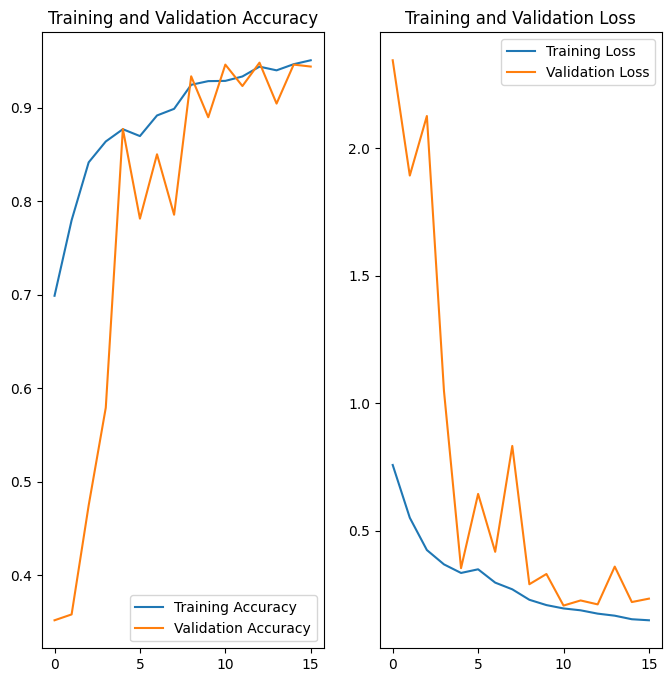

In [17]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

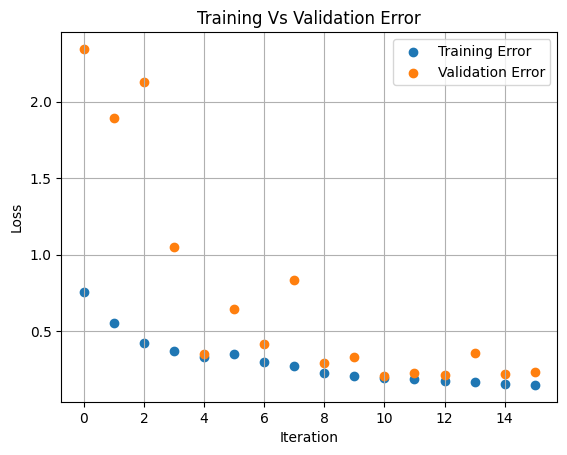

In [18]:
plt.scatter(x=history.epoch,y=history.history['loss'],label='Training Error')
plt.scatter(x=history.epoch,y=history.history['val_loss'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

first image to predict
actual label: Banana Panama Disease
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
predicted label: Banana Panama Disease


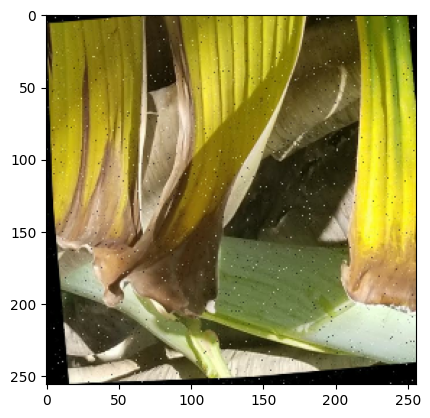

In [19]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


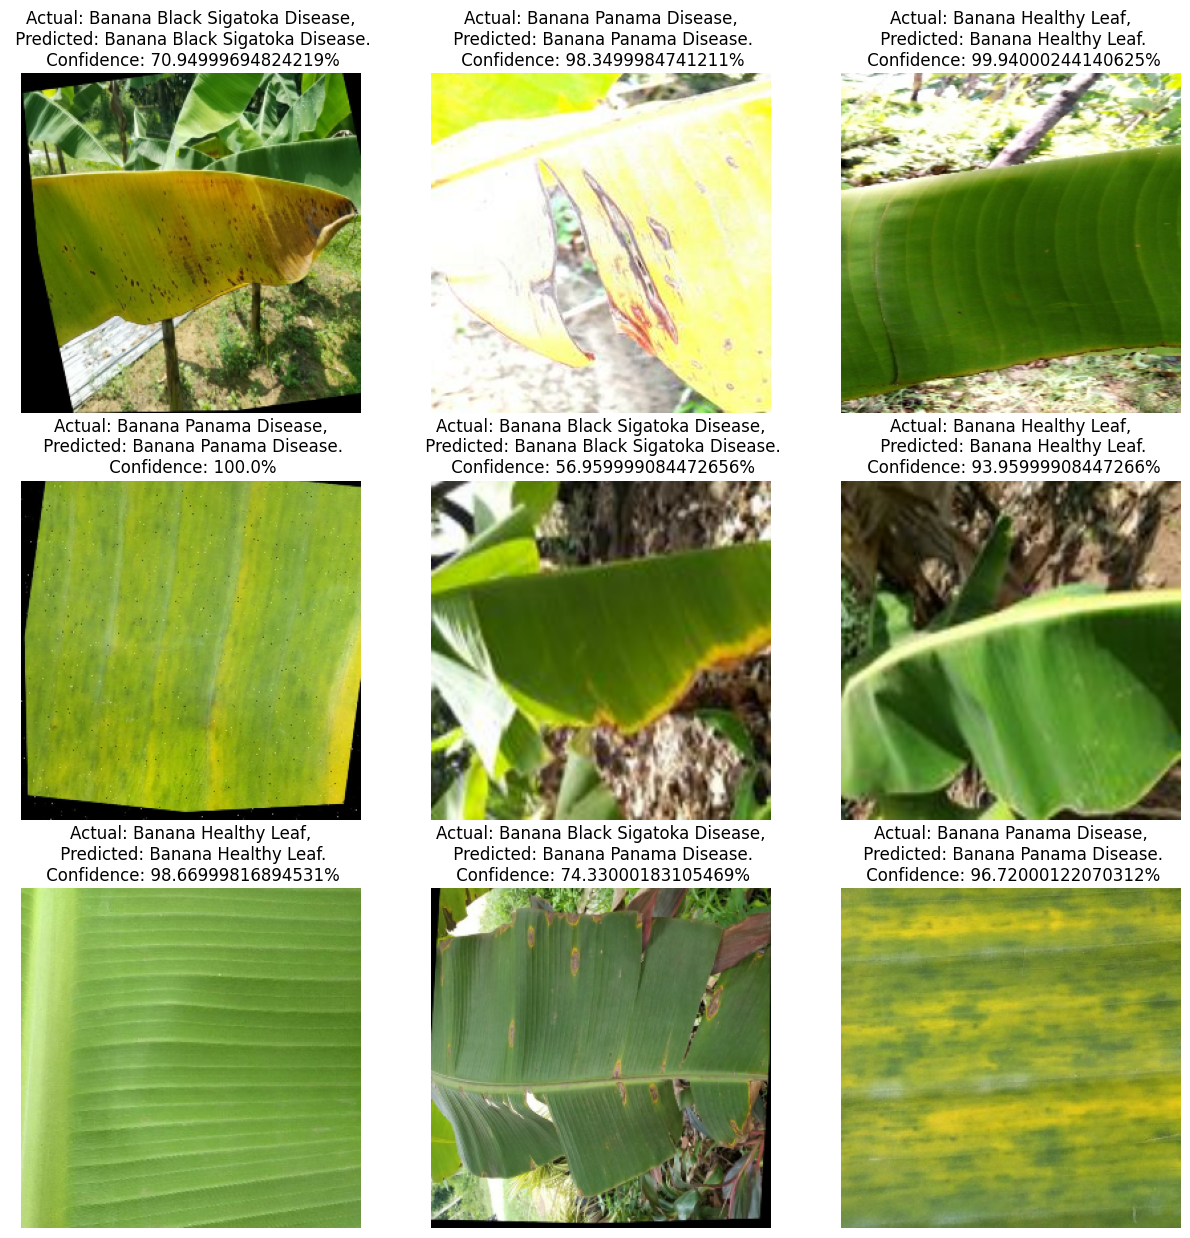

In [20]:
import numpy as np

def predict(model, image):
    """
    Predicts the class of an image using the given model.

    Args:
        model: The trained Keras model.
        image: The image to predict.

    Returns:
        A tuple containing the predicted class name and confidence score.
    """
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    prediction = model.predict(image)
    predicted_class_index = np.argmax(prediction)
    confidence = round(100 * (np.max(prediction)), 2)
    predicted_class = class_names[predicted_class_index]

    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy()) # Call the defined 'predict' function
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")


In [30]:
import os
# Define the models directory
models_dir = "../saved_models/11"

# Ensure the directory exists
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Save the model
model.save(f"{models_dir}/banana_model.keras")
print("Model saved successfully!")

Model saved successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


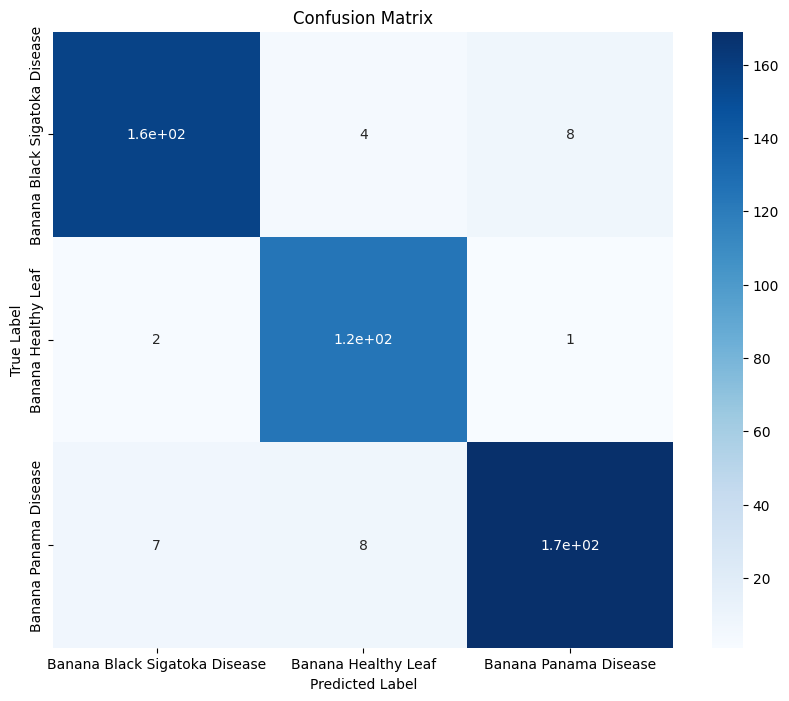

In [22]:
# Generate Confusion Matrix
y_true, y_pred = [], []
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [23]:
# ✅ Define Image Path
image_path = "test_leaf.jpg"

# ✅ Ensure the file exists
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Error: The file '{image_path}' does not exist. Check the path.")

print("✅ File exists:", os.path.exists(image_path))

✅ File exists: True


In [24]:
# ✅ Preprocess Image Function
def preprocess_image(img_path):
    """
    Load and preprocess an image for model prediction.
    """
    IMAGE_SIZE = 256  # Ensure this matches the model input size

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize

    return img_array



In [25]:
# ✅ Grad-CAM Function
def grad_cam(model, img_array, last_conv_layer_name):
    """
    Generates a Grad-CAM heatmap for an input image.
    """
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, tf.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)  # Normalize

    return heatmap

In [26]:
def apply_gradcam(image_path, model, last_conv_layer_name="last_conv_layer"):
    """
    Applies Grad-CAM visualization to an image using the trained model.
    """
    img_array = preprocess_image(image_path)
    heatmap = grad_cam(model, img_array, last_conv_layer_name)

    if heatmap is None:
        raise ValueError("Error: heatmap is not generated. Check the grad_cam function.")

    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Error: Unable to load image from {image_path}. Check the file path.")

    img = cv2.resize(img, (256, 256))

    # Resize and apply colormap to heatmap
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay heatmap onto image
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Display Images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM Heatmap")

    plt.show()
    return superimposed_img  # ✅ Fix: Return the superimposed image

C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


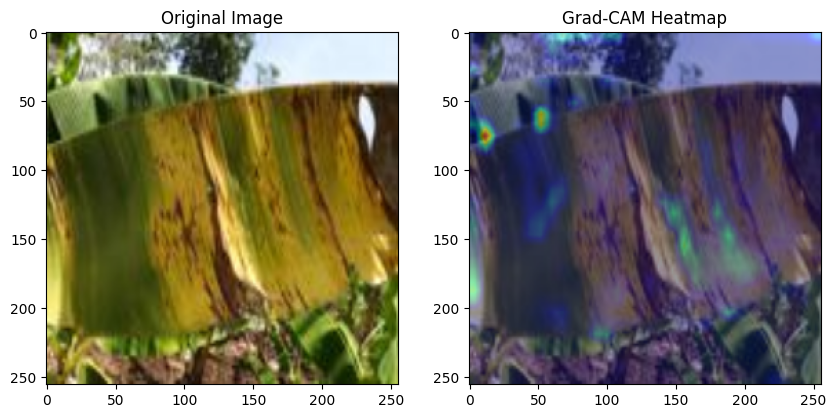

In [27]:
# ✅ Call Grad-CAM and Save the Image
superimposed_img = apply_gradcam("test_leaf.jpg", model)

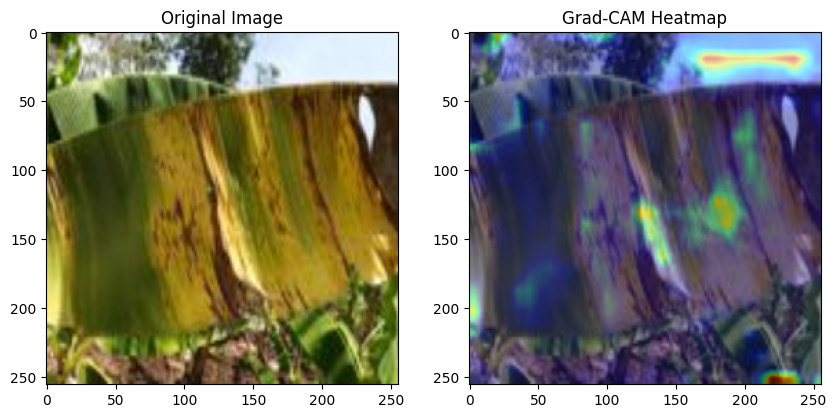

array([[[ 94,  61,  50],
        [ 98,  67,  55],
        [104,  74,  64],
        ...,
        [254, 184, 137],
        [254, 184, 137],
        [254, 184, 137]],

       [[ 93,  61,  49],
        [ 97,  66,  55],
        [103,  74,  64],
        ...,
        [254, 184, 137],
        [254, 184, 137],
        [254, 184, 137]],

       [[ 87,  59,  48],
        [ 92,  65,  54],
        [100,  74,  63],
        ...,
        [254, 184, 137],
        [254, 184, 137],
        [254, 184, 137]],

       ...,

       [[ 98,  54,  47],
        [101,  55,  48],
        [105,  55,  50],
        ...,
        [155, 186, 108],
        [152, 183, 106],
        [149, 181, 104]],

       [[101,  53,  43],
        [103,  53,  44],
        [106,  53,  47],
        ...,
        [152, 186, 107],
        [149, 183, 105],
        [148, 182, 104]],

       [[101,  52,  42],
        [103,  52,  43],
        [106,  52,  46],
        ...,
        [152, 186, 107],
        [149, 183, 105],
        [147, 182, 104]]

In [28]:
# ✅ Run Grad-CAM
apply_gradcam(image_path, model)

In [29]:
# ✅ Save the heatmap
cv2.imwrite("grad_cam_output.jpg", superimposed_img)
print("✅ Grad-CAM image saved as 'grad_cam_output.jpg'")

✅ Grad-CAM image saved as 'grad_cam_output.jpg'


In [31]:
print(MODEL.input_shape)


NameError: name 'MODEL' is not defined

In [34]:
python -c "import tensorflow as tf; print(tf.__version__)"


SyntaxError: invalid syntax (643275380.py, line 1)

In [38]:
import os
# Define the models directory
models_dir = "../saved_models/12"

# Ensure the directory exists
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Save the model
model.save(f"{models_dir}/banana_model.keras")
print("Model saved successfully!")

Model saved successfully!


In [39]:
import tensorflow as tf

model_path = "saved_models/12/banana.keras"
model = tf.keras.models.load_model(model_path)

print("✅ Model Loaded!")
print("Model Expected Input Shape:", model.input_shape)


ValueError: File not found: filepath=saved_models/12/banana.keras. Please ensure the file is an accessible `.keras` zip file.